Meshes allow to manipulate continuous quantities (such as the density field sampled by a Catalog of galaxies) represented on a discrete grid. The 3D mesh of a cubic region of space of slide length `BoxSize` is composed of a total of $Nmesh^3$ small cubes.

A mesh can be produced via one of the following approaches:
- Generate mesh from catalog: interpolating/ smearing out a set of discrete data points into a mesh cell
- Reading mesh from memory
- Generating a mock field directly on a mesh
The processes of filling the mesh with data is referred to as painting.

See Getting Started -> Data on Mesh -> Overview for how to produce a field from a mesh (happens under the hood when using `MeshSource.paint`).

# Creating a Mesh

### Catalog to Mesh
The to_mesh function just initializes a mesh object according to the passed specifications. It does not perform any painting i.e. data interpolation.

In [1]:
from nbodykit.lab import UniformCatalogCatalog

In [3]:
cat = UniformCatalog(nbar=100, BoxSize=1.0, seed=42)
mesh = cat.to_mesh(Nmesh=16)

#### Interpolation kernels
Simplest case: Nearest Grid Point interpolation: an object only contributes to the one cell closest to its position. Higher order interpolation, spreading an object over several cells lead to more accurate results (density field approximation is improved). Different schemes (Cloud in Cell (2nd order): cic or Triangular Shaped Cloud (3rd order): tsc) can be specified via the `resampler` or `window` keyword in `to_mesh`function.

Effects illustrated in Cookbook/Interpolation and Interlacing notebook

#### Compensation
Due to the interpolation step, the data on the mesh is actually the density field convolved with the interpolation kernel. To obtain just the density field, set `compensated=True` in `to_mesh`. 

#### Aliasing and Interlacing
When Fourier transforming the density field on the mesh, sampling is used. For example, when sampling a $\sin$ signal and interpolating the data points, the resulting function (and its frequency) depend on the sampling rate. This can lead to deducing an incorrect frequency of the original signal. This issue is referred to as aliasing. To mitigate this issue (i.e. de-convolving the interpolation), one can combine/ interlace two meshes shifted by half a cell size. To do so, set `interlacing=True` in `to_mesh`.

#### Further keywords
- `value`: Name of catalog column to use as the field/cell value when painting onto the mesh.
- `weight`: Total field/cell value is weighted average value of objects associated to the cell.
- `position = 'Position'`: Specify what catalog column to interpret as the cartesian position of the object. By default it is the `Position` column.

See Getting Started->Painting Catalogs to a Mesh for maths of how the field is painted.

### Gaussian Realizations
Create a density field with a known power spectrum. Contrast to the earlier case where we deduced the density field power spectrum by FT an input galaxy catalog.

In [4]:
from nbodykit.lab import LinearMesh, cosmology
from matplotlib import pyplot as plt

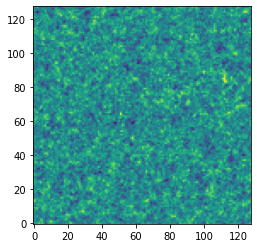

In [19]:
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift=0, transfer='EisensteinHu')

mesh = LinearMesh(Plin, Nmesh=128, BoxSize=1380, seed=42)

# preview density field projected on axes 0 and 1 with value of axis 2 via color
density_field = mesh.preview(axes=[0,1])
plt.imshow(density_field, origin='lower')

### From memory
See Getting Started-> Creating a Mesh for more. Here only from numpy array

In [10]:
from nbodykit.lab import ArrayMesh
import numpy as np

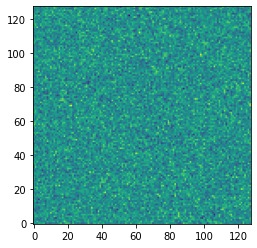

In [18]:
data = np.random.random(size=(128,128,128))
mesh = ArrayMesh(data, BoxSize=1.0)
plt.imshow(mesh.preview(axes=[0,1]), origin='lower')

# Mesh operations

How to preview, see above.

Due to parallel computing, don't use `np.std(field)` or similar methods applied to the entire field. Instead:

In [17]:
field = mesh.compute()
((field**2).cmean() - field.cmean()**2)**0.5

0.2887001866783067

Saving and loading a mesh

In [24]:
from nbodykit.lab import BigFileMesh

In [23]:
mesh.save('random_mesh_FourierSpace.bigfile', mode='complex', dataset='Field')

In [27]:
complex_mesh = BigFileMesh('random_mesh_FourierSpace.bigfile', 'Field')
# get complex field via paint
cfield = complex_mesh.paint(mode='complex')

Applying functions to mesh data

Function passed to `apply()` needs to take 2 arguments, `x` and `v`:
- `x`: list of length 3 holding the coordinate arrays that define the mesh
- `v`: array holding field value at coords defined by `x`

Below, apply a filter function in Fourier space, which changes the field value to the field value divided by the squared norm of the wavenumber coords.

In [29]:
def filter(k, v):
    kk = sum(ki**2 for ki in k)
    kk[kk==0] = 1
    return v/kk

# depending on type of filter/transformation function, need to change mode and
# kind. mode='complex' when transforming in Fourier space and 'real' when in real
# space
filtered_mesh = mesh.apply(filter, mode='complex', kind='wavenumber')